# Combining step protocols with sine waves or ramps

In the next notebooks we will look at a few voltage protocols that have been used in fitting, and discuss the methods most appropriate to each one.

## Adding ramps to a step protocol

Previous notebooks used a [myokit.Protocol](https://myokit.readthedocs.io/en/latest/api_simulations/Protocol.html) to encode a voltage protocol consisting of a sequence of fixed-voltage steps.
In the examples below we'll show how to dynamically update a model's equations to allow more complex shapes such as ramps and sine waves.

In this first part, we'll try to copy the step protocol with ramps from ["Rapid Characterization of hERG Channel Kinetics"](https://doi.org/10.1016/j.bpj.2019.07.029).
We start by loading a CSV version of the protocol.

In [2]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

# Load a CSV file
log_1 = myokit.DataLog.load_csv('resources/protocol-staircaseramp.csv')

# Convert Python lists to NumPy arrays
log_1 = log_1.npview()

# Show the contents of the loaded protocol
print(log_1.keys())

odict_keys(['time', 'voltage'])


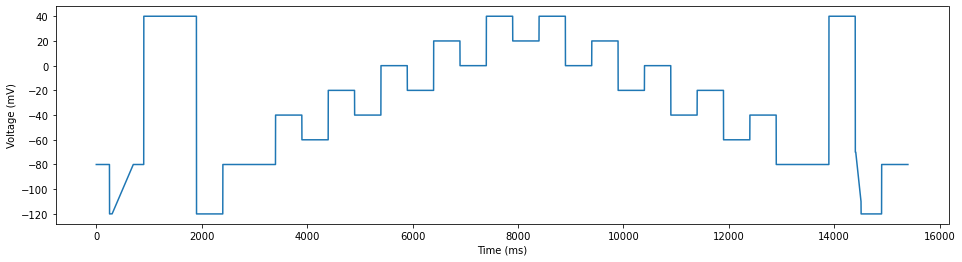

In [3]:
# Convert time to ms
log_1['time'] *= 1000

# Get time just after protocol is finished
tmax = log_1['time'][-1] + 0.1

# Create a plot
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(log_1['time'], log_1['voltage'])
plt.show()

In previous examples, we used a ramp-free version of the protocol:

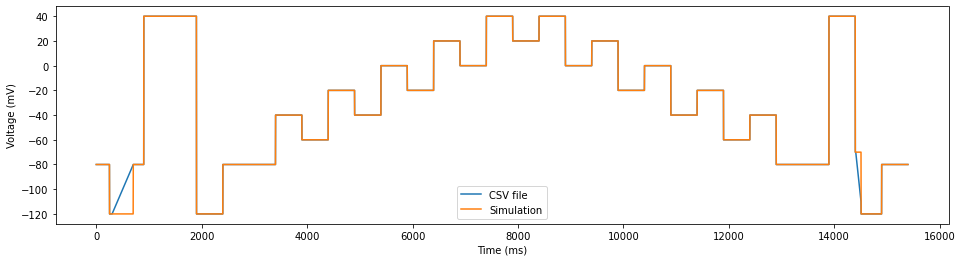

In [4]:
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
sim = myokit.Simulation(model, protocol)

log_2 = sim.run(tmax, log_times=log_1['time'])

plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(log_1['time'], log_1['voltage'], label='CSV file')
plt.plot(log_2['engine.time'], log_2['membrane.V'], label='Simulation')
plt.legend()
plt.show()

To add in the ramps, we inspect the CSV file a bit closer and define equations for both ramps.

#### Ramp 1

$V_1(t=300) = -120$

$V_1(t=700) = -80$

$V_1 = -120 + (t - 300) \cdot 40 / 400 = -150 + t / 10$

#### Ramp 2

$V_1(t=14410) = -70$

$V_1(t=14510) = -110$

$V_2 = -70 + (t - 14410) \cdot -40 / 100 = 5694 - 0.4 t$

We can check graphically that these equations create the lines we want them to.

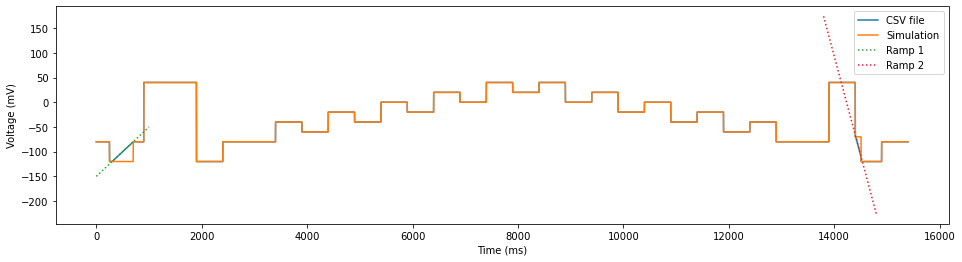

In [5]:
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(log_1['time'], log_1['voltage'], label='CSV file')
plt.plot(log_2['engine.time'], log_2['membrane.V'], label='Simulation')

t1 = np.linspace(0, 1000, 1000)
v1 = -150 + 0.1 * t1

t2 = np.linspace(13800, 14800, 1000)
v2 = 5694 - 0.4 * t2

plt.plot(t1, v1, ':', label='Ramp 1')
plt.plot(t2, v2, ':', label='Ramp 2')

plt.legend()
plt.show()

Now we'll add these ramps into the model, by programmatically modifying the `membrane` component.

In [6]:
print(model.get('membrane').code())

[membrane]
V = 0 [mV] bind pace label membrane_potential




We'll replace this by something of the form:

\begin{align}
v_p  &= \text{step protocol} \\
v_1 &= -150 + 0.1 t \\
v_2 &= 5694 - 0.4 t \\
V  &= \begin{cases}
    v_1 & \mbox{ if } 300 \leq t < 700 \\
    v_2 & \mbox{ if } 14410 \leq t < 14510 \\
    v_p  & \mbox{ otherwise} \\
\end{cases}
\end{align}

In [7]:
# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Get the membrane component
c = model.get('membrane')

# Get the voltage variable, and remove its binding to `pace`
v = c.get('V')
v.set_binding(None)

# Add a v1 variable
v1 = c.add_variable('v1')
v1.set_rhs('-150 + 0.1 * engine.time')

# Add a v2 variable
v2 = c.add_variable('v2')
v2.set_rhs('5694 - 0.4 * engine.time')

# Add a p variable
vp = c.add_variable('vp')
vp.set_rhs(0)
vp.set_binding('pace')

# Set a new right-hand side equation for V
v.set_rhs("""
    piecewise(
        (engine.time >= 300 and engine.time < 700), v1, 
        (engine.time >=14410 and engine.time < 14510), v2, 
        vp)
""")

In [8]:
print(c.code())

[membrane]
V = piecewise(engine.time >= 300 and engine.time < 700, v1, engine.time >= 14410 and engine.time < 14510, v2, vp)
    label membrane_potential
v1 = -150 + 0.1 * engine.time
v2 = 5694 - 0.4 * engine.time
vp = 0 bind pace




We now run a simulation with the updated model and compare.

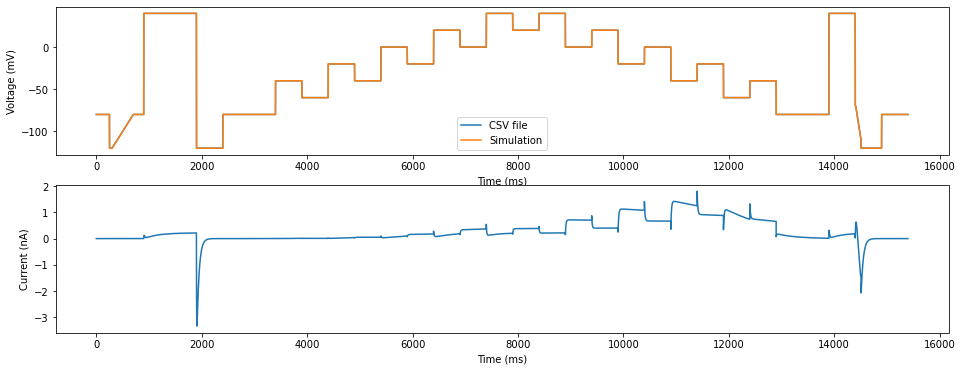

In [9]:
sim = myokit.Simulation(model, protocol)

log_2 = sim.run(tmax + 10, log_times=log_1['time'])

plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(log_1['time'], log_1['voltage'], label='CSV file')
plt.plot(log_2['engine.time'], log_2['membrane.V'], label='Simulation')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(log_2['engine.time'], log_2['ikr.IKr'])

plt.show()

Just to be sure, we inspect the difference.

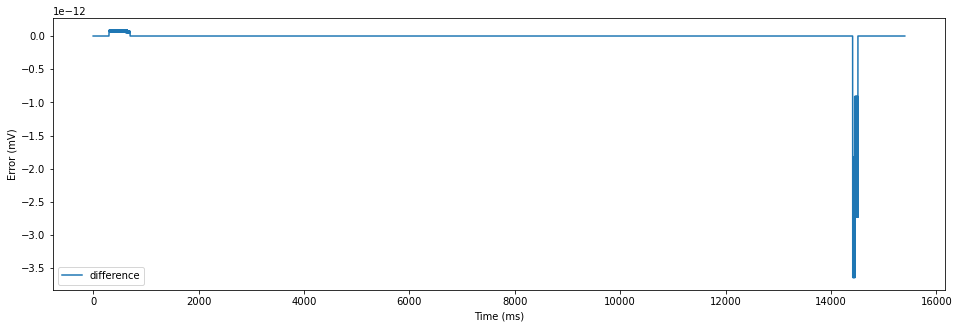

In [10]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Error (mV)')
plt.plot(log_1['time'], log_1['voltage'] - log_2['membrane.V'], label='difference')
plt.legend()
plt.show()

So, we have matched the protocol in the CSV file very closely!

## Combining steps and sine waves

Just like in the example above, we can use a combination of a step protocol and dynamically added equations to implement the sine wave protocol used in ["Sinusoidal voltage protocols for rapid characterisation of ion channel kinetics"](https://doi.org/10.1113/JP275733). 
This is the approach taken in the [code](https://github.com/CardiacModelling/FourWaysOfFitting) for "Four ways of fitting an ion channel model".

Once again, we start from a step protocol.

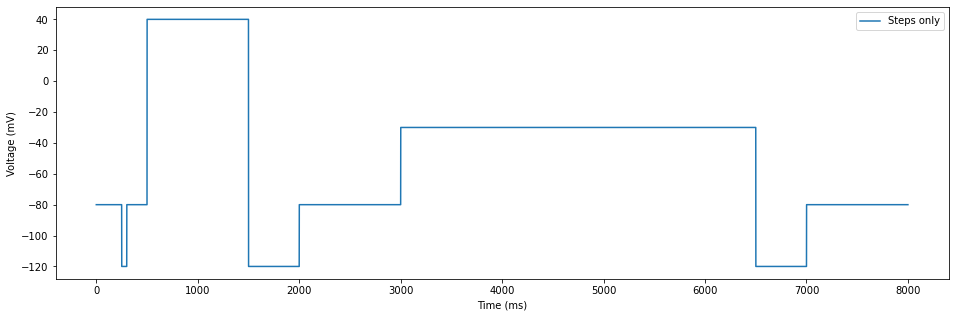

In [12]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
protocol = myokit.load_protocol('resources/sine-wave-steps.mmt')
sim = myokit.Simulation(model, protocol)

tmax = 8000
times = np.linspace(0, tmax, tmax*10)
log_1 = sim.run(tmax, log_times=times)

plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(log_1['engine.time'], log_1['membrane.V'], label='Steps only')
plt.legend()
plt.show()

Next, we dynamically add in the sine waves, using the definitions given in the original paper as our guide.

In [13]:
# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Get the membrane component
c = model.get('membrane')

# Get the voltage variable, and remove its binding to `pace`
v = c.get('V')
v.set_binding(None)

# Add a p variable
vp = c.add_variable('vp')
vp.set_rhs(0)
vp.set_binding('pace')

# Update V's RHS
model.get('membrane.V').set_rhs(
    'if(engine.time >= 3000.1 and engine.time < 6500.1,'
    + ' - 30'
    + ' + 54 * sin(0.007 * (engine.time - 2500.1))'
    + ' + 26 * sin(0.037 * (engine.time - 2500.1))'
    + ' + 10 * sin(0.190 * (engine.time - 2500.1))'
    + ', vp)')


We can now run simulations with the updated model.

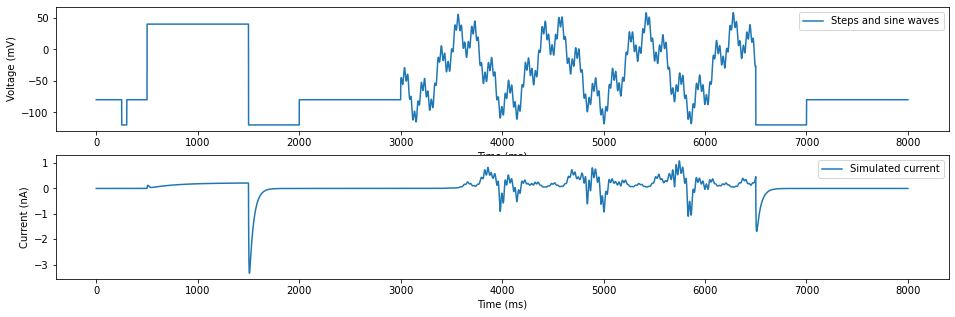

In [14]:
sim = myokit.Simulation(model, protocol)

log_2 = sim.run(tmax, log_times=times)

plt.figure(figsize=(16, 5))

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(log_2['engine.time'], log_2['membrane.V'], label='Steps and sine waves')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(log_2['engine.time'], log_2['ikr.IKr'], label='Simulated current')
plt.legend()

plt.show()

## Discussion

In the examples above, we've seen how `myokit.Protocol` objects can be combined with dynamically added equations to create step protocols with ramp or sine wave sections.
There are other ways such protocols could be implemented, for example using "data clamp" (see the next notebook) or by encoding the entire protocol in the equations.
However, there are some good reasons to prefer the implementation shown here.

Firstly, and most importantly, because a `myokit.Protocol` is implemented as a series of events, the simulation engine is able to determine exactly where each event starts and finishes, and it will pay extra attention to those points in case they contain discontinuities (e.g. the discontinuous step from one voltage to another).
It's possible to embed discontinuities in model equations, but these will either (1) be detected and then pinpointed by the solver in a costly search process, or (2) go undetected.
When using "data clamp" (as seen in the next notebook) the signal is linearly interpolated between any two points, so discontinuities cannot be represented at all.

Secondly, as we'll show later when dealing with real data, because a `myokit.Protocol` contains information about where the discontinuities are, we can use it to deal with capacitance artefacts arising from the voltage jumps.


## Summary

In this notebook we have

- Implemented and simulated a steps-with-ramp protocol.
- Implemented and simulated a steps-with-sine-waves protocol.
- Briefly discussed why a combination of myokit.Protocols and dynamically updated equations are the preferred way to do it.

In the next notebook we will look at implementing even stranger shapes using "data clamp".